In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [118]:
data = pd.read_csv('./tmdb_movies_cleaned.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9953 non-null   int64  
 1   title                       9953 non-null   object 
 2   runtime                     9953 non-null   int64  
 3   release_date                9953 non-null   object 
 4   budget                      9953 non-null   int64  
 5   revenue                     9953 non-null   int64  
 6   popularity                  9953 non-null   float64
 7   vote_average                9953 non-null   float64
 8   vote_count                  9953 non-null   int64  
 9   belongs_to_collection       9953 non-null   int64  
 10  missingness_score           9953 non-null   int64  
 11  has_tagline                 9953 non-null   int64  
 12  has_homepage                9953 non-null   int64  
 13  num_same_title              9953 

In [69]:
def plot_clusters_score(data: pd.DataFrame):
    inertia = []
    silhouette_scores = []
    k_values = list(range(2, 25 + 1))



    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'go-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')

    plt.tight_layout()
    plt.show()

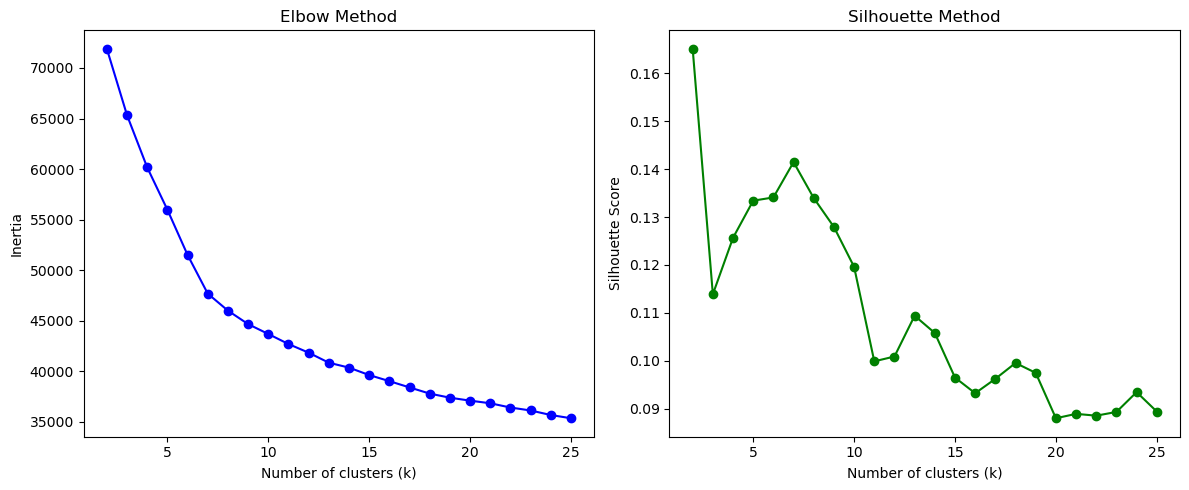

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
data['year-diff'] = data['release_year'].apply(lambda x: 2025-x)

features = [
    'budget', 'runtime', 'num_production_companies',
    'num_genres', 'num_spoken_languages',
    'main_production_country', 'is_english_spoken',
    'release_year', 'Season', 'top10_prod_comps', 'year-diff'
]

numeric_features = [
    'budget', 'runtime', 'num_production_companies',
    'num_genres', 'num_spoken_languages', 'year-diff'
]

categorical_features = [
    'main_production_country', 'Season', 'top10_prod_comps', 'is_english_spoken'
]

# Build the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Optional: Build pipeline (useful for clustering or later steps)
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

kmeans_data = clustering_pipeline.fit_transform(data[features])

plot_clusters_score(kmeans_data)

## good corrolation between the sil-score and the elbow, altogh small score. lets try without the OHE for reducing the dimentaions

In [78]:
kmeans_data = data[numeric_features]
scaler = StandardScaler()

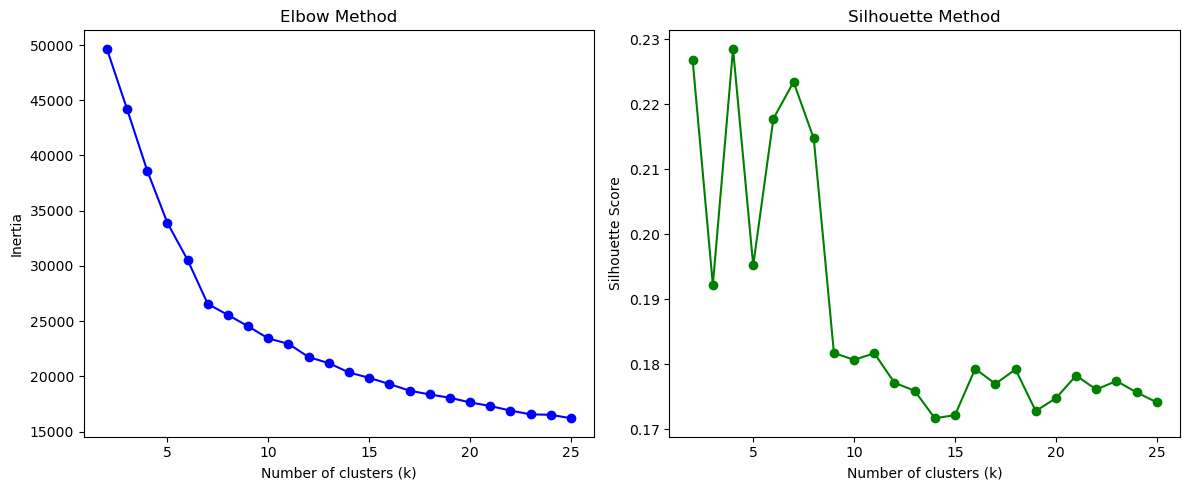

In [ ]:
scaled_data = scaler.fit_transform(kmeans_data)
plot_clusters_score(scaled_data)

In [ ]:
kmeans_data["KMeans_Cluster"] = KMeans(n_clusters=8, random_state=42, max_iter=1000).fit_predict(scaled_data)
sample_for_plot = kmeans_data.sample(3000, random_state=42)

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_11128/1952829927.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



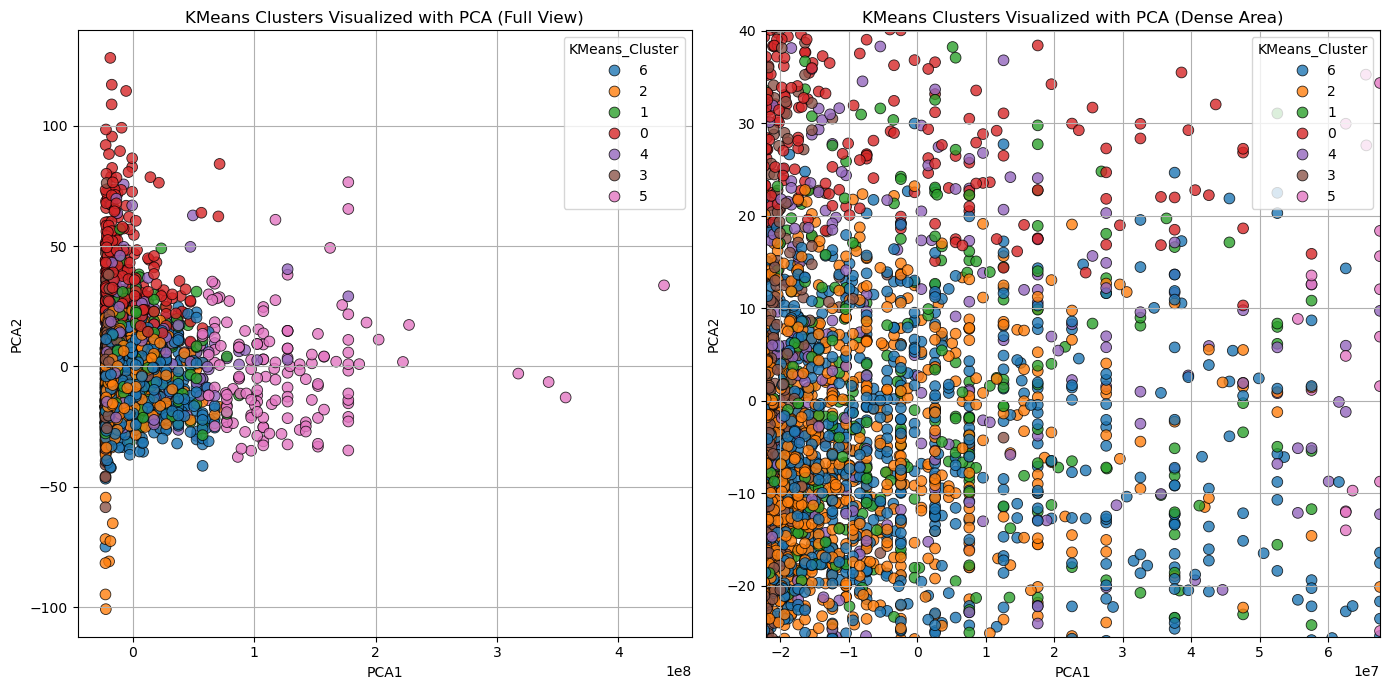

In [83]:
pca = PCA(n_components=2)

reduced = pca.fit_transform(sample_for_plot)

# Create the DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': reduced[:, 0],
    'PCA2': reduced[:, 1],
    'KMeans_Cluster': sample_for_plot['KMeans_Cluster'].astype(str)  # convert to str for color separation
})

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 7)) # Adjust figsize as needed for better layout

# Plot the first scatter plot on the left subplot (axes[0])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[0] # Specify the subplot to draw on
)
axes[0].set_title('KMeans Clusters Visualized with PCA (Full View)')
axes[0].grid(True)
# The legend is often automatically added when using 'hue' with seaborn and matplotlib axes

# Plot the second scatter plot on the right subplot (axes[1])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[1] # Specify the subplot to draw on
)
axes[1].set_title('KMeans Clusters Visualized with PCA (Dense Area)')
axes[1].grid(True)

# Set the limits for the x and y axes for the second subplot to focus on the dense area
# Get percentile-based bounds for a "dense" area (e.g., 5th to 95th percentiles)
x_min, x_max = plot_df['PCA1'].quantile([0.05, 0.95])
y_min, y_max = plot_df['PCA2'].quantile([0.05, 0.95])

# Set tighter zoom for dense plot
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

plt.tight_layout()

# Show the plot
plt.show()

In [84]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

sample_for_plot = kmeans_data.sample(2000, random_state=42)
pca = PCA(n_components=3)
reduced = pca.fit_transform(sample_for_plot)

plot_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2', 'PCA3'])
plot_df['KMeans_Cluster'] = sample_for_plot['KMeans_Cluster'].astype(str)  # for categorical coloring


fig = px.scatter_3d(
    plot_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='KMeans_Cluster', # Color points by cluster
    title='KMeans Clusters Visualized in 3D (PCA)',
    labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2', 'PCA3': 'PCA Component 3'}, # Optional: set axis labels
    size_max=8 # Adjust point size
)

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40), # Adjust margins
    scene=dict( # Update scene to set axis titles
        xaxis_title='PCA1',
        yaxis_title='PCA2',
        zaxis_title='PCA3'
    )
)
fig.update_layout(scene_camera=dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0), # Center of the view
    eye=dict(x=1.25, y=1.25, z=1.25) # Position of the camera
))
fig.show()

## Lets try it with 4 clusters

In [85]:
kmeans_data["KMeans_Cluster"] = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit_predict(scaled_data)
sample_for_plot = kmeans_data.sample(3000, random_state=42)

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_11128/430100388.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



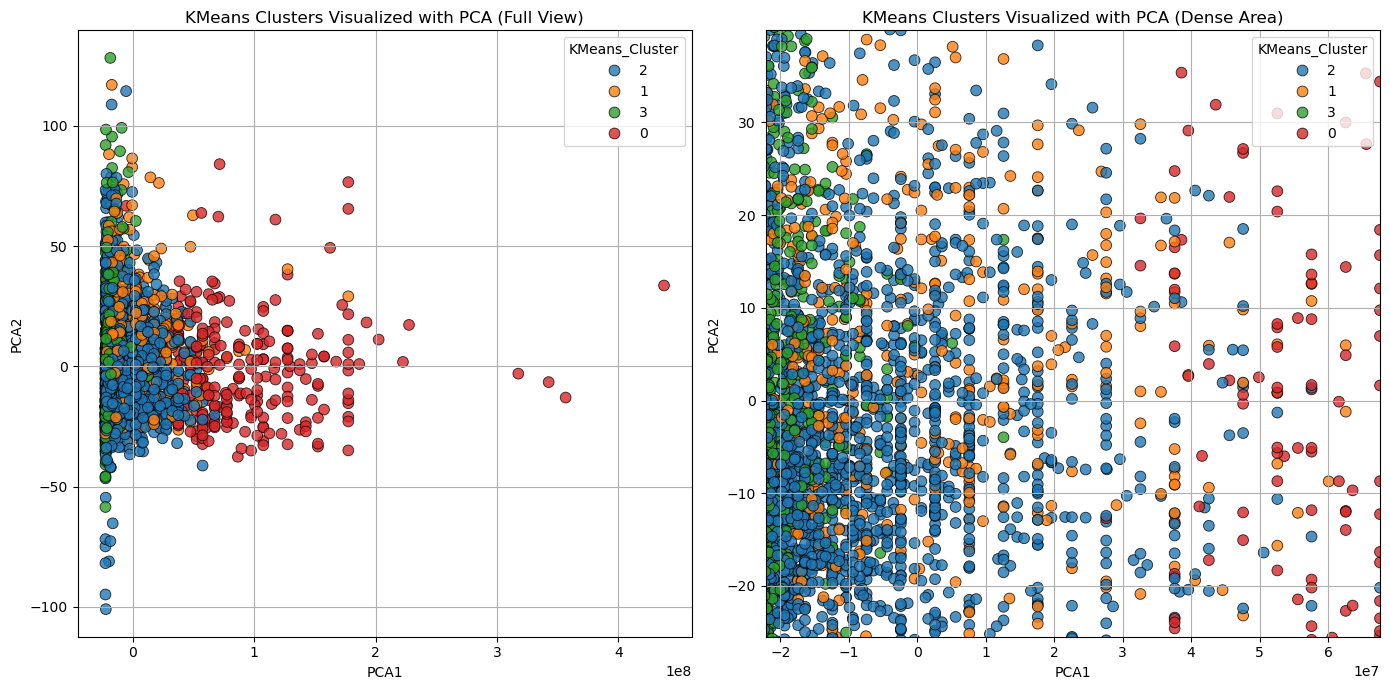

In [86]:
pca = PCA(n_components=2)

reduced = pca.fit_transform(sample_for_plot)

# Create the DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': reduced[:, 0],
    'PCA2': reduced[:, 1],
    'KMeans_Cluster': sample_for_plot['KMeans_Cluster'].astype(str)  # convert to str for color separation
})

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 7)) # Adjust figsize as needed for better layout

# Plot the first scatter plot on the left subplot (axes[0])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[0] # Specify the subplot to draw on
)
axes[0].set_title('KMeans Clusters Visualized with PCA (Full View)')
axes[0].grid(True)
# The legend is often automatically added when using 'hue' with seaborn and matplotlib axes

# Plot the second scatter plot on the right subplot (axes[1])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[1] # Specify the subplot to draw on
)
axes[1].set_title('KMeans Clusters Visualized with PCA (Dense Area)')
axes[1].grid(True)

# Set the limits for the x and y axes for the second subplot to focus on the dense area
# Get percentile-based bounds for a "dense" area (e.g., 5th to 95th percentiles)
x_min, x_max = plot_df['PCA1'].quantile([0.05, 0.95])
y_min, y_max = plot_df['PCA2'].quantile([0.05, 0.95])

# Set tighter zoom for dense plot
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

plt.tight_layout()

# Show the plot
plt.show()

## Because there are much more cat featues in the data and creating OHE for each of them will create a high-dim matrix, i should use k-prototypes for tring to evaluate higher sil-score


Checking for problematic values in the final dataset:
  budget (numerical): min=-0.64, max=9.38
  runtime (numerical): min=-4.64, max=7.47
  num_production_companies (numerical): min=-1.41, max=9.65
  num_genres (numerical): min=-1.47, max=4.30
  num_spoken_languages (numerical): min=-0.52, max=8.53
  main_production_country (categorical): 67 unique values, sample: ['United States of America' 'India' 'Netherlands' 'Italy' 'Greece']
  is_english_spoken (categorical): 2 unique values, sample: [ True False]
  release_year (numerical): min=-4.36, max=1.41
  Season (categorical): 4 unique values, sample: ['Summer' 'Winter' 'Fall' 'Spring']
  top10_prod_comps (categorical): 11 unique values, sample: ['Other' 'Walt Disney' 'Universal Pictures' 'Paramount Pictures'
 '20th Century Fox']
  year (numerical): min=-1.41, max=4.36

Trying K=4, Gamma=0.1...
  Clustering complete for K=4, Gamma=0.1.
  Davies-Bouldin Score: 1.4919
  Calinski-Harabasz Score: 670.1013
  Silhouette Score: 0.2700
  Cost: 

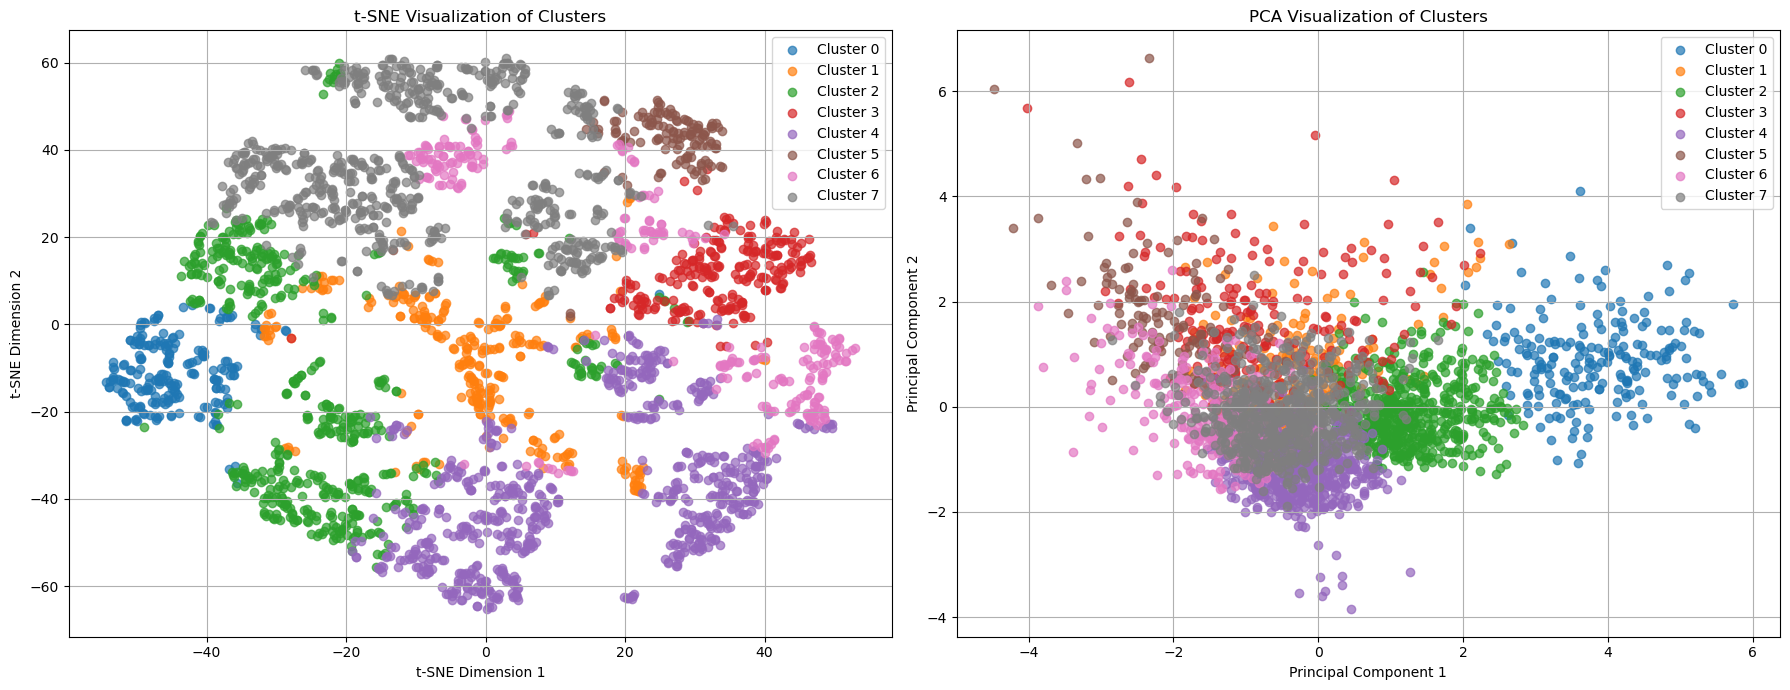


Final results:
{'n_clusters': 8, 'gamma': 0.1, 'davies_bouldin_score': 1.2124920305480875}


In [ ]:
import warnings
data_for_clustering = data[features].sample(3000).copy()

# Get potentially numerical columns
potential_numerical_cols = data_for_clustering.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns

# Check if these columns actually contain only numeric values
truly_numerical_cols = []
for col in potential_numerical_cols:
        pd.to_numeric(data_for_clustering[col], errors='raise')
        truly_numerical_cols.append(col)


# Scale only the truly numerical features
if len(truly_numerical_cols) > 0:
    scaler = StandardScaler()
    data_for_clustering[truly_numerical_cols] = scaler.fit_transform(data_for_clustering[truly_numerical_cols])

# Identify categorical column indices after data type corrections
# KPrototypes expects a list of column indices for categorical features
categorical_cols = data_for_clustering.select_dtypes(include=['object', 'bool', 'category']).columns
categorical_indices = [data_for_clustering.columns.get_loc(col) for col in categorical_cols]




# Convert DataFrame to NumPy array for KPrototypes
X = data_for_clustering.values


results = []
best_davies_bouldin = float('inf')
best_k = None
best_gamma = None
best_labels = None
best_model = None

# 2. Hyperparameter Tuning Loop
for k in [4, 5, 6, 7, 8, 9, 10]:
    for gamma in [0.1, 0.5, 1.0, 2.0, 5.0]:
        print(f"\nTrying K={k}, Gamma={gamma}...")
            # Initialize KPrototypes model
        kp = KPrototypes(
            n_clusters=k,
            gamma=gamma,
            n_init=10,
            random_state=42,
            n_jobs=-1  # Use all available CPU cores
        )

        clusters = kp.fit_predict(X, categorical=categorical_indices)
        
        print(f"  Clustering complete for K={k}, Gamma={gamma}.")

        # Evaluate metrics
        if hasattr(kp, 'cost_'):
            cost = kp.cost_
        else:
            cost = kp.inertia_ if hasattr(kp, 'inertia_') else np.nan
        
        # Extract only numerical columns for scoring
        X_numeric_only = data_for_clustering[truly_numerical_cols].values

        # Initialize default scores in case of failure
        db_score = ch_score = sil_score = np.nan

        # Compute metrics only if clustering produced more than one cluster and we have numeric features
        if len(set(clusters)) > 1 and X_numeric_only.shape[1] > 0:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")

                    db_score = davies_bouldin_score(X_numeric_only, clusters)
                    ch_score = calinski_harabasz_score(X_numeric_only, clusters)
                    sil_score = silhouette_score(X_numeric_only, clusters)

                print(f"  Davies-Bouldin Score: {db_score:.4f}")
                print(f"  Calinski-Harabasz Score: {ch_score:.4f}")
                print(f"  Silhouette Score: {sil_score:.4f}")
            except Exception as e:
                print(f"  Warning: Failed to compute one or more scores due to: {e}")
        else:
            print("  Skipping scoring — only one cluster or no numerical features.")
            db_score = ch_score = sil_score = np.nan
            print("  Skipping score computation (only one cluster or no numeric features)")
        

        print(f"  Cost: {cost:.2f}")
        print(f"  Davies-Bouldin Score: {db_score:.4f}")
        print(f"  Calinski-Harabasz Score: {ch_score:.4f}")
        print(f"  Sil Score: {sil_score:.4f}")

        results.append({
            'n_clusters': k,
            'gamma': gamma,
            'cost': cost,
            'davies_bouldin_score': db_score,
            'calinski_harabasz_score': ch_score
        })

        # Track the best model based on Davies-Bouldin score (lower is better)
        if db_score < best_davies_bouldin:
            best_davies_bouldin = db_score
            best_k = k
            best_gamma = gamma
            best_labels = clusters
            best_model = kp
            print(f"  --> New best model found with K={k}, Gamma={gamma}, DB Score={db_score:.4f}")


results_data = pd.DataFrame(results)
print("\nTuning complete. Summary of results:")

valid_results = results_data.dropna(subset=['davies_bouldin_score'])
if not valid_results.empty:
    print(valid_results.sort_values(by='davies_bouldin_score').head())
else:
    print("No valid results to display.")

final_best_params = {
    'n_clusters': best_k,
    'gamma': best_gamma,
    'davies_bouldin_score': best_davies_bouldin
}
print(f"\nBest parameters found: {final_best_params}")

# 3. Visualization of the best clustering
if best_labels is not None:
    print("\nGenerating 2D visualization of the best clustering using t-SNE...")
        # Check if we have enough samples for t-SNE
    if X.shape[0] < 30:
        print("Warning: Dataset too small for effective t-SNE visualization (< 30 samples)")
        perplexity = min(5, (X.shape[0] - 1) // 3)
    else:
        perplexity = min(30, (X.shape[0] - 1) // 3)
    
    # Use only the numerical features for t-SNE
    X_numeric_only = data_for_clustering[truly_numerical_cols].values

    print("\nGenerating 2D visualizations using t-SNE and PCA...")
    from sklearn.decomposition import PCA

    if X.shape[0] < 30:
        print("Warning: Dataset too small for effective t-SNE visualization (< 30 samples)")
        perplexity = min(5, (X.shape[0] - 1) // 3)
    else:
        perplexity = min(30, (X.shape[0] - 1) // 3)

    # t-SNE
    tsne = TSNE(
        n_components=2, 
        random_state=42,
        perplexity=perplexity,
        learning_rate='auto',
        init='random'
    )
    X_tsne = tsne.fit_transform(X_numeric_only)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_numeric_only)

    # Plot both side by side
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    for label in np.unique(best_labels):
        axes[0].scatter(
            X_tsne[best_labels == label, 0],
            X_tsne[best_labels == label, 1],
            label=f"Cluster {label}",
            alpha=0.7
        )
    axes[0].set_title("t-SNE Visualization of Clusters")
    axes[0].set_xlabel("t-SNE Dimension 1")
    axes[0].set_ylabel("t-SNE Dimension 2")
    axes[0].legend()
    axes[0].grid(True)

    for label in np.unique(best_labels):
        axes[1].scatter(
            X_pca[best_labels == label, 0],
            X_pca[best_labels == label, 1],
            label=f"Cluster {label}",
            alpha=0.7
        )
    axes[1].set_title("PCA Visualization of Clusters")
    axes[1].set_xlabel("Principal Component 1")
    axes[1].set_ylabel("Principal Component 2")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()



# Return results
final_results = {
    'best_params': final_best_params,
    'best_labels': best_labels,
    'best_model': best_model,
    'tuning_results_data': results_data
}

print("\nFinal results:")
print(final_results['best_params'])

##  The k-prototype results after pca visualization looks much better 

In [116]:
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

# Continue from your existing code - using the results from K-Prototypes clustering
print("\nGenerating interactive 3D visualizations...")

# Extract numerical features for 3D dimensionality reduction
X_numeric_3d = data_for_clustering[truly_numerical_cols].values

print(f"Original data shape: {X_numeric_3d.shape}")
print(f"Number of clusters: {len(np.unique(best_labels))}")

# VALIDATION: Check cluster stability with multiple runs
print("\n" + "="*60)
print("CLUSTER VALIDATION AND IMPROVEMENT SUGGESTIONS")
print("="*60)

# 1. Cluster stability test
print("\n1. Testing cluster stability...")
stability_scores = []
n_stability_runs = 5

for run in range(n_stability_runs):
    # Re-run clustering with same parameters but different random state
    kp_stability = KPrototypes(
        n_clusters=best_k,
        gamma=best_gamma,
        n_init=5,
        random_state=42 + run,
        n_jobs=-1
    )
    
    stability_labels = kp_stability.fit_predict(X, categorical=categorical_indices)
    
    # Calculate adjusted rand score compared to best result
    ari_score = adjusted_rand_score(best_labels, stability_labels)
    stability_scores.append(ari_score)

avg_stability = np.mean(stability_scores)
print(f"   Average Adjusted Rand Index: {avg_stability:.4f}")
print(f"   Stability Assessment: {'GOOD' if avg_stability > 0.7 else 'MODERATE' if avg_stability > 0.5 else 'POOR'}")

# 2. Silhouette Score
print("\n2. Computing Silhouette Score...")
sil_score = silhouette_score(X_numeric_3d, best_labels)
print(f"   Silhouette Score: {sil_score:.4f}")
print(f"   Silhouette Assessment: {'EXCELLENT' if sil_score > 0.7 else 'GOOD' if sil_score > 0.5 else 'MODERATE' if sil_score > 0.25 else 'POOR'}")


# Recommendations
print("\n" + "="*60)
print("RECOMMENDATIONS FOR SUPERVISED ML")
print("="*60)

print(f"\nCurrent Setup Analysis:")
print(f"   Davies-Bouldin: {best_davies_bouldin:.4f} ({'GOOD' if best_davies_bouldin < 1.0 else 'MODERATE' if best_davies_bouldin < 1.5 else 'NEEDS IMPROVEMENT'})")
print(f"   Silhouette: {sil_score:.4f} ({'GOOD' if sil_score > 0.3 else 'MODERATE' if sil_score > 0.1 else 'POOR'})")
print(f"   Stability: {avg_stability:.4f} ({'STABLE' if avg_stability > 0.7 else 'MODERATE' if avg_stability > 0.5 else 'UNSTABLE'})")

# Find best alternative configurations
best_alt_k = min(alternative_results, key=lambda x: x['db_score'])
best_alt_gamma = min(gamma_results, key=lambda x: x['db_score'])

print(f"\nBetter Alternatives Found:")
if best_alt_k['db_score'] < best_davies_bouldin:
    print(f"   ✓ K={best_alt_k['k']} gives better DB score: {best_alt_k['db_score']:.4f}")
else:
    print(f"   - Current K={best_k} is optimal for DB score")

if best_alt_gamma['db_score'] < best_davies_bouldin:
    print(f"   ✓ Gamma={best_alt_gamma['gamma']} gives better DB score: {best_alt_gamma['db_score']:.4f}")
else:
    print(f"   - Current Gamma={best_gamma} is optimal for DB score")

# 1. PCA for 3D
print("\n" + "="*40)
print("GENERATING 3D VISUALIZATIONS")
print("="*40)

print("Computing 3D PCA...")
from sklearn.decomposition import PCA
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_numeric_3d)

print(f"PCA explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_3d.explained_variance_ratio_):.3f}")

# 2. t-SNE for 3D
print("Computing 3D t-SNE...")
# Adjust perplexity based on sample size
n_samples_3d = X_numeric_3d.shape[0]
perplexity_3d = min(30, max(5, (n_samples_3d - 1) // 4))

tsne_3d = TSNE(
    n_components=3, 
    random_state=42,
    perplexity=perplexity_3d,
    learning_rate='auto',
    init='random',
    n_iter=1000
)
X_tsne_3d = tsne_3d.fit_transform(X_numeric_3d)

# Create bright color palette for clusters
bright_colors = [
    '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', 
    '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F',
    '#BB8FCE', '#85C1E9', '#F8C471', '#82E0AA'
]
cluster_colors = {cluster: bright_colors[i % len(bright_colors)] for i, cluster in enumerate(np.unique(best_labels))}

# Prepare data for plotting
plot_data = data_for_clustering.copy()
plot_data['Cluster'] = best_labels
plot_data['Cluster_Label'] = [f'Cluster {i}' for i in best_labels]

# Create hover text with feature information
hover_text = []
for idx in range(len(plot_data)):
    text_parts = [f"<b>Cluster {best_labels[idx]}</b><br>"]
    
    # Add numerical features to hover
    for col in truly_numerical_cols[:5]:  # Show first 5 numerical features
        value = plot_data.iloc[idx][col]
        text_parts.append(f"{col}: {value:.3f}<br>")
    
    # Add categorical features to hover
    categorical_cols = data_for_clustering.select_dtypes(include=['object', 'bool', 'category']).columns
    for col in categorical_cols[:3]:  # Show first 3 categorical features
        value = plot_data.iloc[idx][col]
        text_parts.append(f"{col}: {value}<br>")
    
    hover_text.append("".join(text_parts))

# Create main PCA 3D visualization with bright background
print("Creating main 3D PCA visualization...")
fig_main = go.Figure()

for cluster in np.unique(best_labels):
    mask = best_labels == cluster
    fig_main.add_trace(
        go.Scatter3d(
            x=X_pca_3d[mask, 0],
            y=X_pca_3d[mask, 1],
            z=X_pca_3d[mask, 2],
            mode='markers',
            marker=dict(
                size=7,
                color=cluster_colors[cluster],
                opacity=0.8,
                line=dict(width=1.5, color='white')
            ),
            name=f'Cluster {cluster} (n={np.sum(mask)})',
            text=[hover_text[i] for i in np.where(mask)[0]],
            hovertemplate='%{text}<extra></extra>'
        )
    )

fig_main.update_layout(
    title=dict(
        text=f'<b style="color: #2C3E50;">Interactive 3D PCA Clustering Visualization</b><br>' +
             f'<span style="font-size:14px; color: #34495E;">K={best_k} clusters, γ={best_gamma} | ' +
             f'DB Score: {best_davies_bouldin:.4f} | Silhouette: {sil_score:.4f}</span>',
        x=0.5,
        font=dict(size=18)
    ),
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%} variance)',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%} variance)',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%} variance)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
        bgcolor='rgba(248, 249, 250, 1.0)',  # Very light gray/white
        xaxis=dict(
            backgroundcolor='rgba(255, 255, 255, 0.8)',
            gridcolor='rgba(52, 73, 94, 0.3)',
            showbackground=True,
            zerolinecolor='rgba(52, 73, 94, 0.5)'
        ),
        yaxis=dict(
            backgroundcolor='rgba(255, 255, 255, 0.8)',
            gridcolor='rgba(52, 73, 94, 0.3)',
            showbackground=True,
            zerolinecolor='rgba(52, 73, 94, 0.5)'
        ),
        zaxis=dict(
            backgroundcolor='rgba(255, 255, 255, 0.8)',
            gridcolor='rgba(52, 73, 94, 0.3)',
            showbackground=True,
            zerolinecolor='rgba(52, 73, 94, 0.5)'
        )
    ),
    height=900,
    width=1200,
    plot_bgcolor='rgba(248, 249, 250, 1.0)',  # Bright background
    paper_bgcolor='rgba(255, 255, 255, 1.0)',  # White paper background
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='rgba(52, 73, 94, 0.3)',
        borderwidth=1
    ),
    margin=dict(l=0, r=150, t=100, b=0)
)

fig_main.show()

# Create t-SNE 3D visualization with bright background
print("Creating 3D t-SNE visualization...")
fig_tsne = go.Figure()

for cluster in np.unique(best_labels):
    mask = best_labels == cluster
    fig_tsne.add_trace(
        go.Scatter3d(
            x=X_tsne_3d[mask, 0],
            y=X_tsne_3d[mask, 1],
            z=X_tsne_3d[mask, 2],
            mode='markers',
            marker=dict(
                size=7,
                color=cluster_colors[cluster],
                opacity=0.8,
                line=dict(width=1.5, color='white')
            ),
            name=f'Cluster {cluster} (n={np.sum(mask)})',
            text=[hover_text[i] for i in np.where(mask)[0]],
            hovertemplate='%{text}<extra></extra>'
        )
    )

fig_tsne.update_layout(
    title=dict(
        text=f'<b style="color: #2C3E50;">Interactive 3D t-SNE Clustering Visualization</b><br>' +
             f'<span style="font-size:14px; color: #34495E;">Perplexity={perplexity_3d} | ' +
             f'K={best_k}, γ={best_gamma} | DB Score: {best_davies_bouldin:.4f}</span>',
        x=0.5,
        font=dict(size=18)
    ),
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
        bgcolor='rgba(248, 249, 250, 1.0)',  # Very light gray/white
        xaxis=dict(
            backgroundcolor='rgba(255, 255, 255, 0.8)',
            gridcolor='rgba(52, 73, 94, 0.3)',
            showbackground=True,
            zerolinecolor='rgba(52, 73, 94, 0.5)'
        ),
        yaxis=dict(
            backgroundcolor='rgba(255, 255, 255, 0.8)',
            gridcolor='rgba(52, 73, 94, 0.3)',
            showbackground=True,
            zerolinecolor='rgba(52, 73, 94, 0.5)'
        ),
        zaxis=dict(
            backgroundcolor='rgba(255, 255, 255, 0.8)',
            gridcolor='rgba(52, 73, 94, 0.3)',
            showbackground=True,
            zerolinecolor='rgba(52, 73, 94, 0.5)'
        )
    ),
    height=900,
    width=1200,
    plot_bgcolor='rgba(248, 249, 250, 1.0)',  # Bright background
    paper_bgcolor='rgba(255, 255, 255, 1.0)',  # White paper background
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='rgba(52, 73, 94, 0.3)',
        borderwidth=1
    ),
    margin=dict(l=0, r=150, t=100, b=0)
)

fig_tsne.show()

# Print comprehensive summary
print(f"\n" + "="*60)
print("COMPREHENSIVE CLUSTERING ANALYSIS SUMMARY")
print("="*60)

print(f"\nDATA OVERVIEW:")
print(f"  Data points visualized: {len(best_labels):,}")
print(f"  Numerical features: {len(truly_numerical_cols)}")
print(f"  Categorical features: {len(categorical_indices)}")

print(f"\nCLUSTERING RESULTS:")
print(f"  Number of clusters: {len(np.unique(best_labels))}")
print(f"  Best K: {best_k}")
print(f"  Best Gamma: {best_gamma}")

print(f"\nCLUSTER QUALITY METRICS:")
print(f"  Davies-Bouldin Score: {best_davies_bouldin:.4f} ({'GOOD' if best_davies_bouldin < 1.0 else 'MODERATE' if best_davies_bouldin < 1.5 else 'NEEDS IMPROVEMENT'})")
print(f"  Silhouette Score: {sil_score:.4f} ({'GOOD' if sil_score > 0.3 else 'MODERATE' if sil_score > 0.1 else 'POOR'})")
print(f"  Stability (ARI): {avg_stability:.4f} ({'STABLE' if avg_stability > 0.7 else 'MODERATE' if avg_stability > 0.5 else 'UNSTABLE'})")

print(f"\nDIMENSIONALITY REDUCTION:")
print(f"  PCA variance explained: {sum(pca_3d.explained_variance_ratio_):.1%}")
print(f"  t-SNE perplexity used: {perplexity_3d}")

print(f"\nCLUSTER DISTRIBUTION:")
for cluster in np.unique(best_labels):
    count = np.sum(best_labels == cluster)
    percentage = (count / len(best_labels)) * 100
    print(f"  Cluster {cluster}: {count:,} points ({percentage:.1f}%)")

print(f"\n" + "="*60)
print("SUPERVISED ML RECOMMENDATIONS")
print("="*60)

overall_score = 0
if best_davies_bouldin < 1.0:
    overall_score += 2
elif best_davies_bouldin < 1.5:
    overall_score += 1

if sil_score > 0.3:
    overall_score += 2
elif sil_score > 0.1:
    overall_score += 1

if avg_stability > 0.7:
    overall_score += 2
elif avg_stability > 0.5:
    overall_score += 1

print(f"\nOVERALL ARCHETYPE QUALITY: {overall_score}/6 ({'EXCELLENT' if overall_score >= 5 else 'GOOD' if overall_score >= 4 else 'MODERATE' if overall_score >= 2 else 'POOR'})")

print(f"\nRECOMMENDED SUPERVISED ML STRATEGIES:")
print(f"  ✓ Use clusters as categorical features in your model")
print(f"  ✓ Apply stratified sampling based on cluster membership")
print(f"  ✓ Consider ensemble methods with cluster-specific models")
print(f"  ✓ Validate that test sets contain all cluster types")

if overall_score < 4:
    print(f"\nIMPROVEMENT SUGGESTIONS:")
    if best_alt_k['db_score'] < best_davies_bouldin:
        print(f"  → Try K={best_alt_k['k']} (DB Score: {best_alt_k['db_score']:.4f})")
    if best_alt_gamma['db_score'] < best_davies_bouldin:
        print(f"  → Try Gamma={best_alt_gamma['gamma']} (DB Score: {best_alt_gamma['db_score']:.4f})")
    if avg_stability < 0.7:
        print(f"  → Increase n_init parameter for more stable results")
    if sil_score < 0.3:
        print(f"  → Consider feature selection or different preprocessing")



Generating interactive 3D visualizations...
Original data shape: (3000, 7)
Number of clusters: 8

CLUSTER VALIDATION AND IMPROVEMENT SUGGESTIONS

1. Testing cluster stability...
   Average Adjusted Rand Index: 0.9819
   Stability Assessment: GOOD

2. Computing Silhouette Score...
   Silhouette Score: 0.2106
   Silhouette Assessment: POOR

RECOMMENDATIONS FOR SUPERVISED ML

Current Setup Analysis:
   Davies-Bouldin: 1.2125 (MODERATE)
   Silhouette: 0.2106 (MODERATE)
   Stability: 0.9819 (STABLE)

Better Alternatives Found:
   - Current K=8 is optimal for DB score
   - Current Gamma=0.1 is optimal for DB score

GENERATING 3D VISUALIZATIONS
Computing 3D PCA...
PCA explained variance ratio: [0.33490813 0.18155248 0.15011598]
Total variance explained: 0.667
Computing 3D t-SNE...
Creating main 3D PCA visualization...


Creating 3D t-SNE visualization...



COMPREHENSIVE CLUSTERING ANALYSIS SUMMARY

DATA OVERVIEW:
  Data points visualized: 3,000
  Numerical features: 7
  Categorical features: 4

CLUSTERING RESULTS:
  Number of clusters: 8
  Best K: 8
  Best Gamma: 0.1

CLUSTER QUALITY METRICS:
  Davies-Bouldin Score: 1.2125 (MODERATE)
  Silhouette Score: 0.2106 (MODERATE)
  Stability (ARI): 0.9819 (STABLE)

DIMENSIONALITY REDUCTION:
  PCA variance explained: 66.7%
  t-SNE perplexity used: 30

CLUSTER DISTRIBUTION:
  Cluster 0: 212 points (7.1%)
  Cluster 1: 289 points (9.6%)
  Cluster 2: 539 points (18.0%)
  Cluster 3: 235 points (7.8%)
  Cluster 4: 666 points (22.2%)
  Cluster 5: 130 points (4.3%)
  Cluster 6: 272 points (9.1%)
  Cluster 7: 657 points (21.9%)

SUPERVISED ML RECOMMENDATIONS

OVERALL ARCHETYPE QUALITY: 4/6 (GOOD)

RECOMMENDED SUPERVISED ML STRATEGIES:
  ✓ Use clusters as categorical features in your model
  ✓ Apply stratified sampling based on cluster membership
  ✓ Consider ensemble methods with cluster-specific models
 

# Conclutions: overall the kmeans and kprototypes algorithms does not evaluate good results for clusting the the data in terms of production tiers and we can not create new feature as archtype based on these clusters